In [0]:
import re
import json
import fileinput
import pandas as pd
import gensim
import numpy as np
import nltk
import os
import random
import sklearn.metrics
import sklearn.model_selection
from sklearn.manifold import TSNE
import sklearn.datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, TweetTokenizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from google.colab import files
import io

In [4]:
uploaded = files.upload()

Saving train_labeled_data.csv to train_labeled_data (2).csv


In [0]:
df = pd.read_csv(io.StringIO(uploaded['train_labeled_data.csv'].decode('ISO-8859-1')))

In [0]:
df.columns = ["sentiment_label", "tweet_id", "date", "flag", "user", "tweet"]

In [0]:
df.drop(['tweet_id', 'date', 'flag', 'user'], axis=1, inplace=True)

In [0]:
df1 = df[df.sentiment_label.isnull() == False]

In [0]:
df1 = df[df.tweet.isnull() == False]

In [0]:
df1.reset_index(inplace=True)

In [0]:
df1.drop('index', axis=1, inplace=True)

In [0]:
df1['sentiment_label'] = df1['sentiment_label'].map( {4:1, 0:0} )

In [0]:
# Extract features from a given text
def extract_tokens(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = list(filter(lambda t: not t.startswith('@'), tokens))
    tokens = list(filter(lambda t: not t.startswith('#'), tokens))
    tokens = list(filter(lambda t: not t.startswith('http'), tokens))
    
    return tokens

In [0]:
def data_process(data):
    data['tokens'] = data['tweet'].map(extract_tokens)
    
    return data

In [0]:
df1 = data_process(df1)

In [0]:
df1 = df1[df1.tokens != 'NC']
df1.reset_index(inplace=True)
df1.drop('index', inplace=True, axis=1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df1.tokens), np.array(df1.sentiment_label), test_size=0.2)

In [0]:
lsentence = gensim.models.doc2vec.LabeledSentence

In [0]:
def label_tweets(text, ltype):
    labelized = []
    for i,v in tqdm(enumerate(text)):
        label = '%s_%s'%(ltype,i)
        labelized.append(lsentence(v, [label]))
    return labelized

In [26]:
x_train = label_tweets(x_train, 'TRAIN')
x_test = label_tweets(x_test, 'TEST')

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """
1279999it [00:11, 116125.51it/s]
320000it [00:01, 189143.27it/s]


In [27]:
x_train[0]

LabeledSentence(words=['feeling', 'completely', 'out', 'of', 'sorts', '.', 'good', 'food', 'might', 'help', ',', 'but', 'i', "don't", 'have', 'my', 'bike', 'today'], tags=['TRAIN_0'])

In [0]:
n_dim = 500

In [29]:
w2v_model = Word2Vec(size=n_dim, min_count=10)
w2v_model.build_vocab([x.words for x in tqdm(x_train)])
w2v_model.train([x.words for x in tqdm(x_train)], total_examples = w2v_model.corpus_count, epochs = w2v_model.iter )

100%|██████████| 1279999/1279999 [00:00<00:00, 1573124.24it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(69356047, 94127895)

In [30]:
w2v_model.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.7337238788604736),
 ('goood', 0.7152717113494873),
 ('tough', 0.6565498113632202),
 ('nice', 0.649657130241394),
 ('gooood', 0.6495082378387451),
 ('rough', 0.6472073793411255),
 ('fantastic', 0.6289516687393188),
 ('gd', 0.6287442445755005),
 ('goooood', 0.624893069267273),
 ('rubbish', 0.6104312539100647)]

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


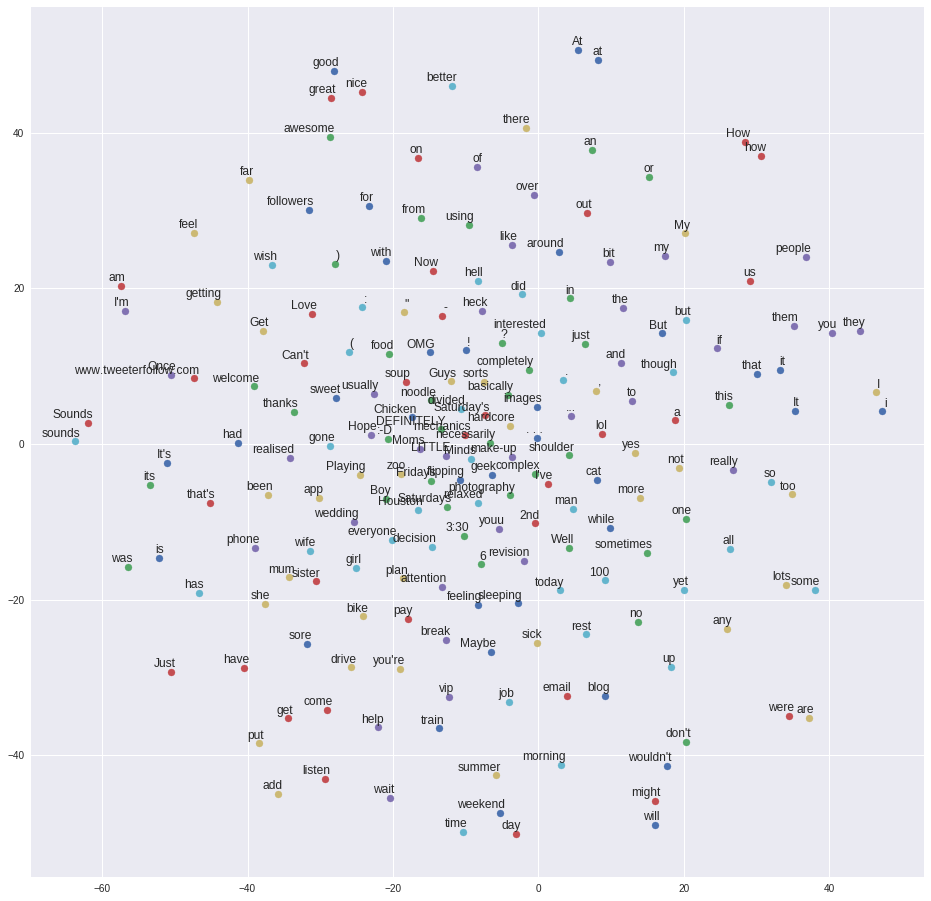

In [32]:
tsne_plot(w2v_model)

In [0]:
build_matrix = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
tfidf_matrix = build_matrix.fit_transform([x.words for x in x_train])
tfidf = dict(zip(build_matrix.get_feature_names(), build_matrix.idf_))

In [0]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [0]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
167453it [00:43, 3825.97it/s]

1279999it [05:41, 3745.36it/s]


In [0]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [0]:
cvscores = []
for train, test in kfold.split(train_vecs_w2v, y_train):
  model = keras.Sequential()
  model.add(Dense(32, activation='relu', input_dim=200))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

  model.fit(train_vecs_w2v[train], y_train[train], epochs=9, batch_size=32, verbose=2)
  
  #y_score = model.predict(test_vecs_w2v)
  
  score = model.evaluate(test_vecs_w2v[], y_test, batch_size=128, verbose=2)